In [1]:
from __future__ import division
from __future__ import print_function

import sys
import os
import argparse
import time
import random
from glob import glob
from datetime import datetime

import align.detect_face
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import misc
from scipy.interpolate import Rbf
from skimage import io, transform
from six.moves import xrange

import tensorflow as tf
import tensorflow.contrib.slim as slim

import facenet
import helper

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

plt.ion() # interactive mode

In [2]:
import dlib

In [3]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('../../dlib_b/python_examples/shape_predictor_68_face_landmarks.dat')

In [3]:
print(tf.__version__)

1.3.0


In [4]:
# if not tf.test.gpu_device_name():
#     warnings.warn('No GPU found. Please use a GPU to train your neural network.')
#     print('no gpu')
# else:
#     print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

In [4]:
# landmarks_frame = pd.read_csv('./face_landmarks_detects.csv')
# file_list = landmarks_frame.image_name.values.tolist()
file_list = glob('./SNF_TESTSET/*')
t_dataset = helper.Dataset('nf',file_list, 160)

In [5]:
print(len(file_list))

105


In [6]:
batch_size = 100

In [7]:
# avgP_container = np.load('f_avgP_list.npz')
# emb_container = np.load('f_emb_list.npz')
avgP_container = np.load('f_avgP_list_wild.npz')
emb_container = np.load('f_emb_list_wild.npz')

train_set = []
test_set = []

for key in sorted(emb_container, key=lambda x: int(x.strip('arr_'))) :
    batch = avgP_container[key], emb_container[key]
    if len(batch[0]) == batch_size :
        train_set.append(batch)
    else :
        test_set.append(batch)

test_set = train_set[-1]
train_set = train_set[0:-1]

In [9]:
t_dataset = helper.Dataset('nf',file_list, 160)

In [8]:
print(t_dataset.shape)
print(len(file_list))
print(len(train_set))
print(len(test_set))

(105, 160, 160, 3)
105
0
2


In [9]:
def l_init() :
    return tf.contrib.layers.variance_scaling_initializer()

In [10]:
# def l_bn(prev_layer, num_units, is_training=False, scope=None) :
#     with tf.variable_scope(scope, 'fc') :
#         layer = tf.layers.dense(prev_layer, 
#                                 num_units, 
#                                 kernel_initializer=l_init(), 
#                                 activation=None)
#         layer = tf.layers.batch_normalization(layer, training=is_training)
#         layer = tf.nn.relu(layer)
#     return layer

In [11]:
def F_layer(net, f_num = 1024, is_training=False) : 
    with tf.variable_scope('F') :
        net = slim.fully_connected(net, f_num, weights_initializer=l_init(),scope='fc0')
    return net

In [12]:
def MLP(net, landmark_num = 68, is_training=False, reuse=None, scope='MLP'):
    """Builds the MLP for landmark"""
    with tf.variable_scope(scope, 'MLP') :
        net = slim.fully_connected(net, 1024, weights_initializer=l_init(), scope='fc0')
        net = slim.fully_connected(net, 512, weights_initializer=l_init(), scope='fc1')
        net = slim.fully_connected(net, 256, weights_initializer=l_init(), scope='fc2')
        net = slim.fully_connected(net, 128, weights_initializer=l_init(), scope='fc3')
        net = slim.fully_connected(net, landmark_num, activation_fn=None, weights_initializer=l_init(), scope='fc4')
    return net

In [13]:
def landmark_decode(net, landmark_num = 68, is_training=False):
    with tf.variable_scope('landmark') :
        decoded_x = MLP(net, is_training=is_training, scope= 'decoded_x')
        decoded_y = MLP(net, is_training=is_training, scope= 'decoded_y')
    return decoded_x, decoded_y

In [14]:
def CNN(F, size) :
    with tf.variable_scope('CNN') :
        # 12 x 12 x 256
        f_size = int(size / 8)
        features = slim.fully_connected(F, f_size * f_size * 256, activation_fn=None, scope="features")
        features = tf.reshape(features, [-1, f_size, f_size, 256])
        # print(features.shape)
        
        # 24 x 24 x 128
        upsample_0 = slim.conv2d_transpose(features, 128, 5, stride=2, scope="upsample_0")
        # print(upsample_0.shape)
        
        # 48 x 48 x 64
        upsample_1 = slim.conv2d_transpose(upsample_0, 64, 5, stride=2, scope="upsample_1")
        # print(upsample_1.shape)
        
        # 96 x 96 x 32
        upsample_2 = slim.conv2d_transpose(upsample_1, 32, 5, stride=2, scope="upsample_2")
        # print(upsample_2.shape)
        
        # 96 x 96 x 3
        one_by_one_conv = slim.conv2d(upsample_2, 3, 1, stride=1, activation_fn=None, scope="one_by_one_conv")
        # print(one_by_one_conv.shape)
    return one_by_one_conv

In [15]:
def texture_decode(net, size) :
    with tf.variable_scope('texture') :
        cnn = CNN(net, size)
    return cnn

In [16]:
def get_grids(size):
    return np.mgrid[0:size-1:(size * 1j), 0:size-1:(size * 1j)]

In [17]:
def get_zero_displacement(size):
    mid = size/2
    end = size-1
    
    zero_displacement = [[0,0], 
                         [0, mid], 
                         [0, end], 
                         [mid, 0], 
                         [end,0], 
                         [end, mid], 
                         [end, end], 
                         [mid, end]]
    return zero_displacement

In [18]:
def rbf_tf(pred_x, pred_y, correct_points, grids, grid_shape):
    def _euclidean_norm_tf(x1, x2):
        euclidean_norm = tf.subtract(x1, x2)
        euclidean_norm = tf.square(euclidean_norm)
        euclidean_norm = tf.reduce_sum(euclidean_norm, 1)
        euclidean_norm = tf.add(euclidean_norm, 1e-10)
        #euclidean_norm = tf.clip_by_value(euclidean_norm, 0.1, 10**5)
        euclidean_norm = tf.sqrt(euclidean_norm)
        return euclidean_norm
        
        with tf.variable_scope('euclidean_norm') :
            euclidean_norm = tf.sqrt(tf.reduce_sum(((x1 - x2)**2), 1))
        return euclidean_norm

    def _h_linear_tf(r):
        return r

    def _call_norm_tf(x1, x2):
        with tf.variable_scope('norm') :
            x1 = tf.expand_dims(x1, 3)
            x2 = tf.expand_dims(x2, 2)
            n = norm(x1, x2)
        return n

    # set parameters
    norm = _euclidean_norm_tf
    basis_function = _h_linear_tf
    epsilon = tf.constant(2.)
    smooth = tf.constant(1.)

    xi = tf.stack([pred_x, pred_y], axis= 1)
    N = xi.shape[-1].value # same as landmarks_num => 76
    di = tf.expand_dims(correct_points, 2) # (None, 76, 1)
    
    r = _call_norm_tf(xi, xi) # (None, 76, 76)
    
    batch_shape = tf.shape(pred_x)[0:1]
    A = tf.subtract(basis_function(r), tf.multiply(smooth, tf.eye(N, batch_shape= batch_shape)))
    
    nodes = tf.matrix_solve (A, di)
    r2 = _call_norm_tf(grids, xi)
    return tf.reshape(tf.matmul(r2, nodes), [-1, grid_shape[0], grid_shape[1]])

In [19]:
def warp_tf(data, pred_x, pred_y, correct_x, correct_y, grids, grid_shape, zero_displacement) :
    with tf.variable_scope('pred') :
        pred_x_zd = tf.concat([pred_x, zero_displacement[0]], axis=1)
        pred_y_zd = tf.concat([pred_y, zero_displacement[1]], axis=1)
    with tf.variable_scope('correct') :
        correct_x_zd = tf.concat([correct_x, zero_displacement[0]], axis=1)
        correct_y_zd = tf.concat([correct_y, zero_displacement[1]], axis=1)

    with tf.variable_scope('rbf_x') :
        rbf_x = rbf_tf(pred_x_zd, pred_y_zd, correct_x_zd, grids, grid_shape)
    with tf.variable_scope('rbf_y') :
        rbf_y = rbf_tf(pred_x_zd, pred_y_zd, correct_y_zd, grids, grid_shape)

    with tf.variable_scope('resample') :
        warp = tf.stack([rbf_x, rbf_y], axis= 3)
        resample = tf.contrib.resampler.resampler(data=data, warp=warp)
    return resample

In [20]:
# summary
base_dir = os.path.expanduser('logs')
subdir = datetime.strftime(datetime.now(), '%Y%m%d-%H%M%S')
log_dir = os.path.join(base_dir, subdir)
loss_file_name = log_dir + "/loss.txt"

def make_path(file_name) :
    if not os.path.exists(os.path.dirname(file_name)):
        try:
            os.makedirs(os.path.dirname(file_name))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    return file_name

print(make_path(loss_file_name))

# hyperparam
epochs = 100
learning_rate = 0.001

chk_interval = 10
log_interval = 100

avgP_num = 1792
emb_num = 128
f_num = 1792

l_num = 68
zd_l_num = 76
t_size = 160
t_channel = 3

batch_size = 100

grid_y, grid_x = get_grids(t_size)
grid_shape = grid_x.shape

_xa = np.asarray([a.flatten() for a in [grid_x, grid_y]], dtype=np.float32) # (2, 25600)
xa = np.asarray([_xa for _ in range(0, batch_size)], dtype=np.float32) # (batch_size, 2, 25600)
xa_t = np.asarray([_xa], dtype=np.float32)

_zd = get_zero_displacement(t_size)
zd = np.asarray([_zd for _ in range(0, batch_size)], dtype=np.float32)
zd_t = np.asarray([_zd], dtype=np.float32)

logs/20171029-040440/loss.txt


In [21]:
g = tf.Graph()
with g.as_default():
    global_step = tf.Variable(0, trainable=False)
    
    # placeholder
    avgP_inputs = tf.placeholder(tf.float32, (None, avgP_num), name='avgP_inputs')
    
    l_x_labels = tf.placeholder(tf.float32, (None, l_num), name='l_x_labels')
    l_y_labels = tf.placeholder(tf.float32, (None, l_num), name='l_y_labels')
    t_labels = tf.placeholder(tf.float32, (None, t_size, t_size, t_channel), name='t_labels')
    w_labels = tf.placeholder(tf.float32, shape=(None, emb_num), name= 'w_labels')
    
    is_training = tf.placeholder(tf.bool)
    
    grids = tf.constant(xa, dtype=tf.float32, name= 'grids')
    grids_test = tf.constant(xa_t, dtype=tf.float32, name= 'grids')
    
    zero_displacement = (tf.constant(zd[:, :, 0], dtype=tf.float32, name= 'zd_x'), 
                         tf.constant(zd[:, :, 1], dtype=tf.float32, name= 'zd_y'))
    zero_displacement_test = (tf.constant(zd_t[:, :, 0], dtype=tf.float32, name= 'zd_x_t'), 
                              tf.constant(zd_t[:, :, 1], dtype=tf.float32, name= 'zd_y_t'))
    
    # model
    F = F_layer(avgP_inputs, f_num= f_num, is_training=is_training)
    
    (l_x_preds, l_y_preds) = landmark_decode(F, landmark_num= l_num, is_training=is_training)
    
    l_x_loss = tf.losses.mean_squared_error(l_x_labels, l_x_preds, reduction="weighted_mean")
    l_y_loss = tf.losses.mean_squared_error(l_y_labels, l_y_preds, reduction="weighted_mean")
    
    l_loss = tf.add(l_x_loss, l_y_loss)
    
    t_preds = texture_decode(F, t_size)
    t_loss = tf.losses.absolute_difference(t_labels, t_preds)
    
    with tf.variable_scope('warp') :
        warp = warp_tf(t_preds, 
                       l_x_preds, 
                       l_y_preds, 
                       l_x_labels, 
                       l_y_labels, 
                       grids, 
                       grid_shape, 
                       zero_displacement)
        
    with tf.variable_scope('warp_t') :
        warp_t = warp_tf(t_preds, 
                         l_x_preds, 
                         l_y_preds, 
                         l_x_labels, 
                         l_y_labels, 
                         grids_test, 
                         grid_shape, 
                         zero_displacement_test)
        warp_t = tf.cast(warp_t, tf.uint8)
    
    # w_loss = tf.losses.mean_squared_error(t_labels, warp)
    # total_cost = l_loss + t_loss + w_loss
#     total_cost = l_loss
    
#     extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#     with tf.control_dependencies(extra_update_ops):
#         opt = tf.train.AdamOptimizer(learning_rate).minimize(total_cost)
        
#     config = tf.ConfigProto(allow_soft_placement = True)
#     sess = tf.Session(config = config) 
#     sess.run(tf.global_variables_initializer())

In [22]:
with g.as_default():
    time_load_data = time.time()
    
    #facenet
    start_load_facenet = time.time()
    print("--- %s start load facenet ---" % (start_load_facenet))
    facenet.load_model('./20171012', input_map={"input:0": warp})
    print("--- %s facenet loaded ---" % (time.time() - start_load_facenet))

    f_phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
    w_preds = tf.get_default_graph().get_tensor_by_name("embeddings:0")
    
    w_labels = tf.nn.l2_normalize(w_labels, 1)
    w_preds = tf.nn.l2_normalize(w_preds, 1)
    w_loss = tf.losses.cosine_distance(w_labels, w_preds, dim=1)
    
    total_cost = l_loss + t_loss + w_loss
    
    opt = tf.train.AdamOptimizer(learning_rate).minimize(total_cost)    
    
    config = tf.ConfigProto(allow_soft_placement = True)
    sess = tf.Session(config = config)
    
#     grads = tf.gradients(total_cost, tf.trainable_variables())
#     grads = list(zip(grads, tf.trainable_variables()))
#     apply_grads = opt.apply_gradients(grads_and_vars=grads)
    
#     for grad, var in grads:
#         tf.summary.histogram(var.op.name + '/gradient', grad)
    
#     for var in tf.trainable_variables():
#         tf.summary.histogram(var.op.name, var)
    
#     summary_op = tf.summary.merge_all()
#     summary_writer = tf.summary.FileWriter(log_dir, sess.graph)    
    
    sess.run(tf.global_variables_initializer())

--- 1509249884.2513 start load facenet ---
Model filename: ./20171012
--- 3.974485158920288 facenet loaded ---


In [23]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    if landmarks is not None : 
        plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='b')

In [24]:
def get_landmarks(index) :
    index = len(train_set) * batch_size + index
    return landmarks_frame.ix[index]

In [75]:
# def show_test(l_x, l_y, img, l):
#     plt.figure()
#     plt.imshow(io.imread(os.path.join('', img)))
#     plt.scatter(l_x, l_y, s=10, marker='.', c='b')
#     plt.show()
    
def show_test(l_x, l_y, t, w, img, l):
    if img is not None :
        plt.figure()
        show_landmarks(io.imread(os.path.join('', img)), l)
        plt.show()
    
    t_img = scipy.misc.toimage(t)
    plt.imshow(t_img)
    plt.scatter(l_x, l_y, s=10, marker='.', c='b')
    plt.pause(0.001)
    plt.show()

    if w is not None : 
        #plt.scatter(l_x, l_y, s=10, marker='.', c='r')
        plt.imshow(w)
        plt.show()

In [26]:
def write_test_image(dir_name, e, l_x, l_y, t, w, i):
    t_img = scipy.misc.toimage(t)
    w_img = scipy.misc.toimage(w)
    o_img = scipy.misc.toimage(i)
    
    lt_file_name = dir_name + '/' + str(e) + '_lt.jpg'
    w_file_name = dir_name + '/' + str(e) + '_w.jpg'
    o_file_name = dir_name + '/' + str(e) + '_o.jpg'
    
    misc.imsave(lt_file_name, t_img)
    misc.imsave(w_file_name, w_img)
    misc.imsave(o_file_name, o_img)

Iter: 10/767Training loss: X = 7391.8460, Y = 8259.4473, T = 110.6852, W = 0.7725
Iter: 20/767Training loss: X = 7296.2411, Y = 8206.3576, T = 58.3845, W = 0.3473
Iter: 30/767Training loss: X = 7225.3508, Y = 8082.7460, T = 46.8841, W = 0.4143
Iter: 40/767Training loss: X = 7083.9572, Y = 7972.0629, T = 44.0780, W = 0.4169
Iter: 50/767Training loss: X = 6978.5053, Y = 7801.2135, T = 41.9115, W = 0.4224
Iter: 60/767Training loss: X = 6843.4810, Y = 7661.6785, T = 40.8010, W = 0.2888
Iter: 70/767Training loss: X = 6690.6496, Y = 7504.3930, T = 39.3087, W = 0.2144
Iter: 80/767Training loss: X = 6525.8331, Y = 7362.9068, T = 37.6243, W = 0.1975
Iter: 90/767Training loss: X = 6334.8607, Y = 7197.4316, T = 37.2164, W = 0.1913
Iter: 100/767Training loss: X = 6187.0887, Y = 7047.7542, T = 36.6743, W = 0.1791
Iter: 110/767Training loss: X = 6014.3489, Y = 6871.7315, T = 36.5219, W = 0.1584
Iter: 120/767Training loss: X = 5851.9547, Y = 6652.3320, T = 35.9148, W = 0.1469
Iter: 130/767Training lo

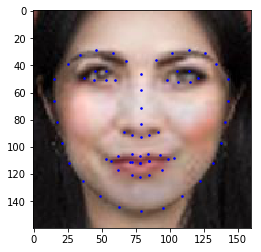

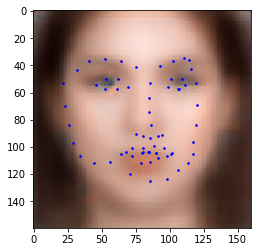

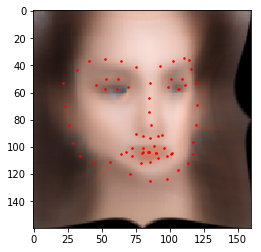

Epoch: 1/300 Time: 2080.4346129894257
Iter: 10/767Training loss: X = 71.6858, Y = 82.2909, T = 29.7114, W = 0.0642
Iter: 20/767Training loss: X = 65.8673, Y = 74.9984, T = 30.4863, W = 0.0615
Iter: 30/767Training loss: X = 62.9060, Y = 74.1228, T = 30.2395, W = 0.0622


KeyboardInterrupt: 

In [28]:
with g.as_default():
    with sess.as_default() :
        start_test = time.time()
        
        for e in range(epochs):
            l_x_cost_sum = 0
            l_y_cost_sum = 0
            t_cost_sum = 0
            w_cost_sum = 0
            
            for i, ((f_avgP, f_emb), t_label_batch) in enumerate(zip(train_set, t_dataset.get_batches(batch_size))):
                start = i * batch_size
                end = min(start+batch_size, len(train_set) * batch_size)
                size = end - start

                l_labels = landmarks_frame.ix[start:end - 1, 1:].as_matrix().astype('float32').reshape(size, l_num, 2)
                
                run = [l_x_loss, 
                       l_y_loss, 
                       t_loss, 
                       w_loss,
                       opt]
                
                feed_dict = {avgP_inputs : f_avgP.reshape(-1, avgP_num),
                             l_x_labels : l_labels[:, :, 0].reshape(-1, l_num), 
                             l_y_labels : l_labels[:, :, 1].reshape(-1, l_num),
                             t_labels : t_label_batch, 
                             w_labels : f_emb.reshape(-1, emb_num), 
                             f_phase_train_placeholder:False,
                             is_training : True}

                out = sess.run(run, feed_dict= feed_dict)
                (l_x_cost, 
                 l_y_cost, 
                 t_cost, 
                 w_cost, 
                 _) = out
                
                l_x_cost_sum += l_x_cost
                l_y_cost_sum += l_y_cost
                t_cost_sum += t_cost
                w_cost_sum += w_cost

                if (i+1) % log_interval == 0 :
                    loss_log = "Iter: {}/{}".format(i+1, len(train_set))
                    loss_log += "Training loss: X = {:.4f}, Y = {:.4f}, T = {:.4f}, W = {:.4f}".format(l_x_cost_sum / log_interval, 
                                                                                                       l_y_cost_sum / log_interval, 
                                                                                                       t_cost_sum / log_interval, 
                                                                                                       w_cost_sum / log_interval)
                    print(loss_log)
                    f = open(loss_file_name, "a")
                    f.write(loss_log +'\n')
                    f.close
                    l_x_cost_sum = 0
                    l_y_cost_sum = 0
                    t_cost_sum = 0
                    w_cost_sum = 0


            if (e+1) % 1 == 0 :
                test_index = random.randint(0, len(test_set[0])-1)
                test_avgP = test_set[0][test_index] 
                t_landmarks = get_landmarks(test_index)

                t_img = misc.imread(t_landmarks[0])
                t_l_labels = t_landmarks[1:].as_matrix().astype('float32').reshape(-1, 2)
            
                test_run = [l_x_preds, l_y_preds, t_preds, warp_t]
                test_feed = {avgP_inputs : test_avgP.reshape(-1, avgP_num),
                             l_x_labels : t_l_labels[:, 0].reshape(-1, l_num), 
                             l_y_labels : t_l_labels[:, 1].reshape(-1, l_num), 
                             is_training : False}

                t_l_x, t_l_y, t_t, t_w = sess.run(test_run, feed_dict= test_feed)

                show_test(t_l_x.reshape(l_num),
                          t_l_y.reshape(l_num), 
                          t_t.reshape(t_size, t_size, t_channel), 
                          t_w.reshape(t_size, t_size, t_channel), 
                          t_landmarks[0], 
                          t_l_labels)
#                 write_test_image(log_dir, e, 
#                                  t_l_x.reshape(l_num),
#                                  t_l_y.reshape(l_num), 
#                                  t_t.reshape(t_size, t_size, t_channel), 
#                                  t_w.reshape(t_size, t_size, t_channel), 
#                                  t_img.reshape(t_size, t_size, t_channel))
                
            print("Epoch: {}/{}".format(e+1, epochs), "Time: %s" % (time.time() - start_test))
            
#             chk_name = log_dir + "/chk/" + str(int((e+1)/chk_interval)) + "/nf.ckpt"
#             chk_name = make_path(chk_name)
#             saver = tf.train.Saver()
#             save_path = saver.save(sess, chk_name)
#             print("Model saved in file: %s" % save_path, "Time: %s" % (time.time() - start_test))

In [77]:
with g.as_default():
    saver = tf.train.Saver()

    # Later, launch the model, use the saver to restore variables from disk, and
    # do some work with the model.
    with sess.as_default():
        # Restore variables from disk.
        saver.restore(sess, "./logs/20171027-101745/chk/0/nf.ckpt")
        print("Model restored.")

INFO:tensorflow:Restoring parameters from ./logs/20171027-101745/chk/0/nf.ckpt
Model restored.


In [78]:
def detect_landmarks(img, num_landmarks = 68) :
    scipy.misc.imsave('tmp.jpg',img)
    img = scipy.misc.imread('tmp.jpg')
    dets = detector(img, 1)  # face detection

    # ignore all the files with no or more than one faces detected.
    if len(dets) == 1:
        row = []

        d = dets[0]
        # Get the landmarks/parts for the face in box d.
        shape = predictor(img, d)
        for i in range(num_landmarks):
            part_i_x = shape.part(i).x
            part_i_y = shape.part(i).y
            row += [[part_i_x, part_i_y]]
        return np.asarray(row, dtype=np.float32) 
    else :
        return None

In [82]:
with g.as_default():
    for i in range(0, len(test_set[0])) :
        test_index = i #random.randint(0, len(test_set[0])-1)
        test_avgP = test_set[0][test_index] 
        t_img = file_list[test_index]

        test_run = [l_x_preds, l_y_preds, t_preds]
        test_feed = {avgP_inputs : test_avgP.reshape(-1, avgP_num),
                     is_training : False}

        t_l_x, t_l_y, t_t = sess.run(test_run, feed_dict= test_feed)

        dl = detect_landmarks(t_t.reshape(t_size, t_size, t_channel))
        if dl is not None :
            dl = dl.reshape(-1, 2)
            test_run = warp_t
            test_feed = {avgP_inputs : test_avgP.reshape(-1, avgP_num),
                         l_x_labels : dl[:,0].reshape(-1, l_num), 
                         l_y_labels : dl[:,1].reshape(-1, l_num)}

            t_w = sess.run(test_run, feed_dict= test_feed)

            show_test(t_l_x.reshape(l_num),
                      t_l_y.reshape(l_num), 
                      t_t.reshape(t_size, t_size, t_channel), 
                      t_w.reshape(t_size, t_size, t_channel), 
                      t_img, 
                      None)
        print(i)
                
#         test_index = random.randint(0, len(test_set[0])-1)
#         test_avgP = test_set[0][test_index] 
#         t_landmarks = get_landmarks(test_index)

#         t_img = t_landmarks[0]
#         t_l_labels = t_landmarks[1:].as_matrix().astype('float32').reshape(-1, 2)

#         test_run = [l_x_preds, l_y_preds, t_preds, warp_t]
#         test_feed = {avgP_inputs : test_avgP.reshape(-1, avgP_num),
#                      l_x_labels : t_l_labels[:, 0].reshape(-1, l_num), 
#                      l_y_labels : t_l_labels[:, 1].reshape(-1, l_num)}

#         t_l_x, t_l_y, t_t, t_w = sess.run(test_run, feed_dict= test_feed)
        
#         show_test(t_l_x.reshape(l_num), 
#                   t_l_y.reshape(l_num), 
#                   t_t.reshape(t_size, t_size, t_channel),
#                   t_w.reshape(t_size, t_size, t_channel), 
#                   t_img, 
#                   t_l_labels)

# Embeding Facenet

In [30]:
def load_and_align_data(image_paths, image_size, margin, gpu_memory_fraction):
    dir_name="./faces_generate"
    replace_name = 'faces_detects'
    
    minsize = 20 # minimum size of face
    threshold = [ 0.6, 0.7, 0.7 ]  # three steps's threshold
    factor = 0.709 # scale factor
    
    print('Creating networks and loading parameters')
    with tf.Graph().as_default():
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_memory_fraction)
        sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
        with sess.as_default():
            pnet, rnet, onet = align.detect_face.create_mtcnn(sess, None)
  
    nrof_samples = len(image_paths)
    img_list = [None] * nrof_samples
    
    error_count = 0
    for i in range(nrof_samples):
        try : 
            path = os.path.expanduser(image_paths[i])
            img = misc.imread(path)
            if (img.shape[2] == 4):
                img = img[:, :, :3]
            img_size = np.asarray(img.shape)[0:2]
            bounding_boxes, _ = align.detect_face.detect_face(img, minsize, pnet, rnet, onet, threshold, factor)
            det = np.squeeze(bounding_boxes[0,0:4])
            bb = np.zeros(4, dtype=np.int32)
            bb[0] = np.maximum(det[0]-margin/2, 0)
            bb[1] = np.maximum(det[1]-margin/2, 0)
            bb[2] = np.minimum(det[2]+margin/2, img_size[1])
            bb[3] = np.minimum(det[3]+margin/2, img_size[0])
            cropped = img[bb[1]:bb[3],bb[0]:bb[2],:]
            aligned = misc.imresize(cropped, (image_size, image_size), interp='bilinear')
            prewhitened = facenet.prewhiten(aligned)
            img_list[i] = prewhitened

#             new_path = path.replace(dir_name, replace_name)
#             misc.imsave(new_path, prewhitened)
        except :
            error_count += 1
        sys.stdout.write('\r'+ '%d/%d - %d'%(i, nrof_samples, error_count))
        #sys.stdout.write('\r'+ '%d/%d - %d : %s'%(i, nrof_samples, error_count, new_path))
    images = np.stack(img_list)
    return images

In [11]:
batch_size = 100

f_emb_g = tf.Graph()
f_emb_list = []
f_avgP_list = []

In [15]:
file_list = glob('./SNF_TESTSET/*')

In [16]:
print(len(file_list))

105


In [14]:
with f_emb_g.as_default():
    time_load_data = time.time()
    print("--- data loading start ---")
    load_and_align_data(file_list, 160, 44, 1.0)
    print("--- %s data loaded ---" % (time.time() - time_load_data))

--- data loading start ---
Creating networks and loading parameters
104/105 - 0 : ./SNF_TESTSET/011318.jpg--- 6.0214080810546875 data loaded ---


In [ ]:
with f_emb_g.as_default():
    time_load_data = time.time()
    print("--- data loading start ---")
    images = load_and_align_data(file_list, 160, 44, 1.0)
    print("--- %s data loaded ---" % (time.time() - time_load_data))
    
    with tf.Session() as sess:
        start_load_facenet = time.time()
        print("--- %s start load facenet ---" % (start_load_facenet))
        facenet.load_model('./20171012')
        print("--- %s facenet loaded ---" % (time.time() - start_load_facenet))

        # Get input and output tensors
        f_inputs = tf.get_default_graph().get_tensor_by_name("input:0")
        f_phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
        f_avgP_logits = tf.get_default_graph().get_tensor_by_name("InceptionResnetV1/Logits/AvgPool_1a_8x8/AvgPool:0")
        f_emb_logits = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        
        start_test = time.time()
        
        total_size = len(images)
        for i in range(0, total_size, batch_size):
            batch = images[i:min(i+batch_size, total_size)]
            f_feed = {f_inputs: batch, f_phase_train_placeholder:False}
            f_embedings, f_avgPool = sess.run([f_emb_logits, f_avgP_logits], feed_dict=f_feed)
            f_emb_list.append(f_embedings)
            f_avgP_list.append(f_avgPool)
            sys.stdout.write('\r'+ "[%d/%d] %s" % (i, total_size, time.time() - start_test))
            print()
        print("--- %s seconds ---" % (time.time() - start_test))

--- data loading start ---
Creating networks and loading parameters
22591/76893 - 1 : faces_detects/36345.jpg

In [28]:
np.savez('f_emb_list.npz', *f_emb_list)
np.savez('f_avgP_list.npz', *f_avgP_list)

In [10]:
import glob
import matplotlib.pyplot as plt
def show_data(n,m):
    dir_name="./faces_detects"
    
    file_list = []
    file_list.extend(glob.glob(dir_name + '/*'))
    print(len(file_list))
    
    for p in file_list[n:m] :
        path = os.path.expanduser(p)
        print(path)
        img = misc.imread(path)
        plt.imshow(np.uint8(img))
        plt.show()

76892
./faces_detects/55798.jpg


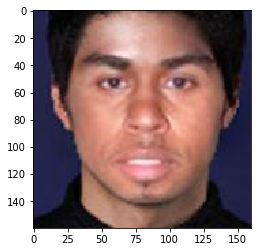

./faces_detects/4211.jpg


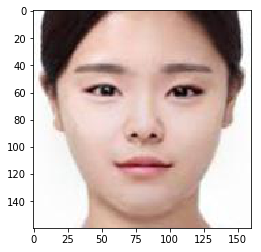

./faces_detects/45442.jpg


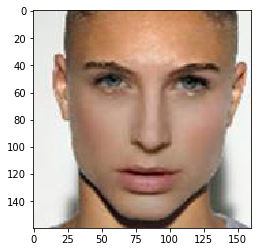

./faces_detects/84986.jpg


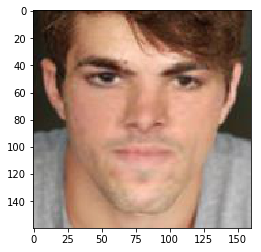

./faces_detects/49387.jpg


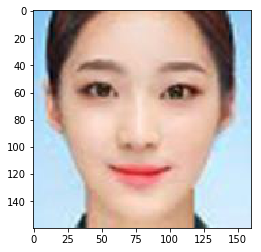

./faces_detects/44797.jpg


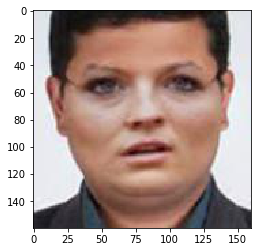

./faces_detects/90084.jpg


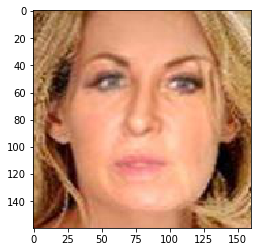

./faces_detects/9332.jpg


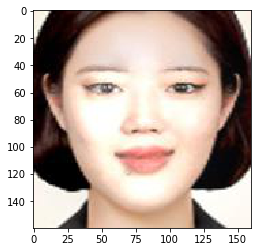

./faces_detects/80216.jpg


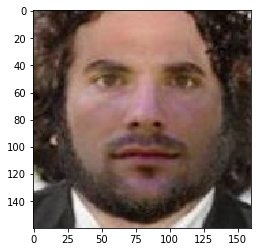

./faces_detects/29430.jpg


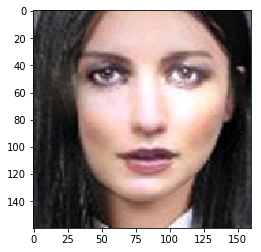

In [13]:
show_data(1100, 1110)

In [54]:
print(images.shape)

(7867, 160, 160, 3)
